In [1]:
# TODO
# Create function to get all edge IDs for a given Adm2 Unit

# Create function to extract deforestation data for edge
# - Add weighting option (distance-based from river)
# - Add river width-based weighting option
# - Allow choice between simple buffer and slope-based buffer

# Network model

In [2]:
import pickle
import warnings
import sqlite3
import shapely
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from multiprocessing import Pool
from collections import defaultdict
import xarray as xr
import rioxarray as rxr
import os
import tempfile
from pysheds.grid import Grid
from rasterio.io import MemoryFile
import cv2
from itertools import chain, product
import pyproj
import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import river_network, calculate_distance_from_estuary

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/msc_rivers.feather").to_crs(5641)
rivers_subset = gpd.clip(rivers, grid_data.geometry.iloc[i])

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine = "pyogrio").to_crs(5641)
boundaries_subset = gpd.clip(boundaries, grid_data.geometry.iloc[i])

---

In [3]:
rivers_brazil = pickle.load(open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/network.pkl", "rb"))
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

---

In [4]:
rivers_brazil_shapefile = calculate_distance_from_estuary(rivers_brazil_shapefile, rivers_brazil_topology)

---

In [5]:
# # create shapely polygons on a grid, spanning the entire planet with a resolution of 1 degrees
# grid = gpd.GeoDataFrame(geometry = [shapely.geometry.box(i, j, i+1, j+1) for i in range(-180, 180, 1) for j in range(-90, 90, 1)])
# boundaries_limits = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio").to_crs(5641).buffer(200 * 1e3).to_crs(4326)
# grid["in_bbox"] = grid.intersects(shapely.geometry.box(*boundaries_limits.total_bounds))
# grid["in_boundaries"] = grid.intersects(boundaries_limits.geometry.iloc[0])grid_filtered = grid.copy()[grid.in_bbox]
# grid_filtered = grid_filtered[grid_filtered.centroid.map(lambda x: x.coords[0][0]) < -32.5]
# grid_filtered["formatted_lon"] = grid_filtered.bounds.minx.map(lambda x: "W" + str(int(x*-1)).zfill(3) if x < 0 else "E" + str(int(x)).zfill(3))
# grid_filtered["formatted_lat"] = grid_filtered.bounds.miny.map(lambda x: "S" + str(int(x*-1)).zfill(2) if x < 0 else "N" + str(int(x)).zfill(2))
# grid_filtered["filename"] = grid_filtered.apply(lambda x: f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00/DEM/Copernicus_DSM_30_{x.formatted_lat}_00_{x.formatted_lon}_00_DEM.tif", axis = 1)

In [6]:
filedir_dem_cop = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/"
files_dem_cop = pd.Series(os.listdir(filedir_dem_cop))
files_dem_cop = files_dem_cop[~files_dem_cop.str.contains(r"\.tar$")]
files_dem_cop = files_dem_cop.map(lambda x: f"{filedir_dem_cop}{x}/DEM/{x}_DEM.tif")

In [7]:
# mfdataset = [rxr.open_rasterio(file, chunks = True)[0,:-1,:-1] for file in files_dem_cop] #grid_filtered[grid_filtered.in_boundaries]["filename"]
# height_profile = xr.combine_by_coords(mfdataset)

---

In [8]:
# spatial join to associate river network with drainage areas
# split where multiple rivers in one polygon
# dissolve by river

# - Opt A: Simple polygons (closest point)
# for each query point, find closest point on exterior of drainage area
# at end node, take residual part of drainage area
# use pysheds to generate weighting matrix

# - Opt B: Complex polygons (exact watershed)
# compute weighting matrices to find best fit sink point for each query point
# compute exact watershed for each query point within the drainage area

In [9]:
from data.preprocess.drainage_areas import expand_bounds

In [10]:
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.feather")
drainage_polygons_projected = drainage_polygons.to_crs(5641)
drainage_polygons_gridded = grid_data.sjoin(gpd.GeoDataFrame(geometry = drainage_polygons_projected.centroid, index = drainage_polygons_projected.index), how = "right").dropna(subset = ["index_left"])

In [11]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/temp_update_set.pkl", "rb") as f:
    update_set = pickle.load(f)

In [12]:
# there was a bug in the script for the 10hr run of the fix
# if there was no polygon to fix in a given grid cell, the script returned None
# this bug is now fixed for future re-runs; I impute these values here
for idx in [idx for idx, val in update_set.items() if val is None]:
    update_set[idx] = drainage_polygons.loc[drainage_polygons_gridded.index[drainage_polygons_gridded.index_left == idx].values].to_crs(5641)

In [13]:
# class SeparationException(Exception):
#     def __init__(self, message):
#         super().__init__(message)

# def extract_first_series(numbers):
#     # Find the index where the next number is significantly smaller than the current number
#     # which we assume to be the start of the new series starting from zero
#     for i in range(1, len(numbers)):
#         if numbers[i] < numbers[i - 1]:
#             # Return two parts: from the start to the transition point, and from the transition point to the end
#             return numbers[:i]
#     # If no transition found, return the whole array as one part, and an empty array for the second part
#     raise SeparationException("Not able to separate series into two parts.")

# # get all indices to remove
# indices_to_remove = np.concatenate([extract_first_series(val.index.values) for idx, val in update_set.items() if val is not None])

In [14]:
# drainage_area_new = pd.concat([drainage_polygons_projected.drop(index = indices_to_remove), pd.concat(update_set).reset_index(drop = True)], ignore_index=True)
drainage_area_new = pd.concat(update_set).reset_index(drop = True)

In [15]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8,6))
# test.to_crs(4326).plot(ax = ax, color = "none", edgecolor = "black")
# update_set.plot(ax = ax, color = "none", edgecolor = "red")
# joined.to_crs(4326).plot(ax = ax, color = "green", alpha = .25)

---

In [16]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/drainage_polygons.pkl", "rb") as f:
    drainage_polygons = pickle.load(f)

In [17]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/experiments/drainage_polygons_dissolved.pkl", "rb") as f:
    drainage_polygons_dissolved = pickle.load(f)

In [18]:
def load_height_profile(bbox):
    lat_lon = product([f"E{int(lat):03}" if lat >= 0 else f"W{-int(lat):03}" for lat in np.arange(np.floor(bbox[0]), np.ceil(bbox[2]), 1)],
                      [f"N{int(lon):02}" if lon >= 0 else f"S{-int(lon):02}" for lon in np.arange(np.floor(bbox[1]), np.ceil(bbox[3]), 1)])
    files_dem_cop = [f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/DEM_GLO-90/Copernicus_DSM_30_{lon}_00_{lat}_00/DEM/Copernicus_DSM_30_{lon}_00_{lat}_00_DEM.tif" for lat, lon in lat_lon]
    # load height profile
    height_profile = xr.combine_by_coords([rxr.open_rasterio(file, chunks = True)[0,:-1,:-1] for file in files_dem_cop])
    # clip height profile
    height_profile = height_profile.rio.clip_box(*bbox)
    return height_profile

In [48]:
def edge_fix(query_points, c_polygon_half):
    # merge and segmentize the polygon half
    t_polygon_half = shapely.line_merge(c_polygon_half).segmentize(10)
    # get the points on the polygon half closest to the query point
    t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]
    # get the direction in which he iterate on the polygon half, cutting it bit by bit
    t_direction = t_polygon_half.line_locate_point(t_nearest_points[0], normalized = True) < .1
    # iterate until the distance between the two points is greater than 1
    while ((t_nearest_points[0].distance(t_nearest_points[1]) < 1) & (t_polygon_half.length > 200)):
        # shorten the line to by 1000 meters
        if t_direction:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance = 5)).geoms[1]
        else:
            t_polygon_half = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(-1000), t_polygon_half, tolerance = 5)).geoms[0]
        # get the points on the polygon half closest to the query point
        t_nearest_points = shapely.ops.nearest_points([shapely.Point(x) for x in query_points], t_polygon_half)[1]
    return t_polygon_half

def compute_polygons_river(payload, rivers, drainage_polygons):
    # extract payload
    c_polygon = payload.geometry
    c_polygon_projected = gpd.GeoSeries([c_polygon], crs=4326).to_crs(5641).values[0]
    c_river = rivers.query(f"river == {payload.river} & estuary == {payload.estuary}")
    c_river = c_river[c_river.to_crs(4326).bounds.apply(lambda x: shapely.geometry.box(*x).intersection(c_polygon).area > 0, axis = 1)]
    
    # get all coordinates of the river
    c_river_coerced = shapely.geometry.MultiLineString(list(chain(*[[x] if isinstance(x, shapely.geometry.LineString) else list(x.geoms) for x in c_river.geometry.values])))
    c_river_coords = np.concatenate([x.coords for x in c_river_coerced.geoms])
    # check if the ends of the river are within the polygon
    t_ends_within = [shapely.Point(c_river_coords[0]).within(c_polygon_projected), shapely.Point(c_river_coords[-1]).within(c_polygon_projected)]
    # if not, add the closest point on the exterior of the polygon
    if t_ends_within[0]:
        c_river_coords = np.concatenate([shapely.ops.nearest_points(shapely.Point(c_river_coords[0]), c_polygon_projected.exterior)[1].coords, c_river_coords])
    if t_ends_within[1]:
        c_river_coords = np.concatenate([c_river_coords + shapely.ops.nearest_points(shapely.Point(c_river_coords[-1]), c_polygon_projected.exterior)[1].coords])
    # split the polygon by the river
    t_split_polygon = shapely.ops.split(c_polygon_projected, shapely.geometry.LineString(c_river_coords))
    # get the part of the exterior of the polygon that is not part of the river
    c_polygon_halves = [x.exterior.difference(shapely.geometry.LineString(c_river_coords)) for x in t_split_polygon.geoms]
    
    to_snap_points_projected = []
    to_snap_points = []
    ## determine segments
    for i in range(c_river.shape[0]):
        # get number of cuts
        c_cuts = int((c_river.iloc[i].geometry.length + c_river.iloc[i].segment_offset) // cut_length)
        # get points to snap
        if c_cuts == 0:
            to_snap = np.concatenate([np.array(c_river.iloc[i].geometry.coords[0]).reshape(1,-1), np.array(c_river.iloc[i].geometry.coords[-1]).reshape(1,-1)])
        else:
            to_snap = np.concatenate([np.array(c_river.iloc[i].geometry.coords[0]).reshape(1,-1), np.array([c_river.iloc[i].geometry.interpolate(cut_length * (ii + 1)).coords for ii in range(c_cuts)]).reshape(-1,2), np.array(c_river.iloc[i].geometry.coords[-1]).reshape(1,-1)])
        #
        to_snap_points_projected += [np.apply_along_axis(shapely.Point, 1, to_snap)]
        to_snap_points += [gpd.GeoSeries(to_snap_points_projected[-1], crs=5641).to_crs(4326).values]
    
    ## apply edge fix
    c_polygon_halves = [edge_fix([to_snap_points[0][0], to_snap_points[0][1]], x) for x in c_polygon_halves]
    c_polygon_halves = [edge_fix([to_snap_points[-1][-2], to_snap_points[-1][-1]], x) for x in c_polygon_halves]
    
    ## drainage-approximating polygons
    polygons_da = [compute_polygons_edge(0, shapely.Polygon(), payload, c_river, c_polygon_halves, to_snap_points[0], to_snap_points_projected[0])]
    for i in tqdm(range(1, c_river.shape[0])):
        polygons_da += [compute_polygons_edge(i, shapely.ops.unary_union(list(chain(*polygons_da[:i]))), payload, c_river, c_polygon_halves, to_snap_points[i], to_snap_points_projected[i])]
        
    def helper(polygons, i):
        return gpd.GeoDataFrame({
        "estuary": c_river.estuary.iloc[i], "river": c_river.river.iloc[i], "segment": c_river.segment.iloc[i], "subsegment": c_river.subsegment.iloc[i], 
        "distance_from_estuary": list(np.arange((c_river.distance_from_estuary.iloc[i] // 1000) * 1000 + 1000 * (len(polygons[i]) - 1), (c_river.distance_from_estuary.iloc[i] // 1000) * 1000, -1000)) + [c_river.distance_from_estuary.iloc[i]], 
        "geometry": polygons[i]
        })
    polygons_da = pd.concat([helper(polygons_da, i) for i in range(c_river.shape[0])])
    return polygons_da#.plot(edgecolor = "black", column = "distance_from_estuary", legend = True)

test = compute_polygons_river(drainage_polygons_dissolved.query("river==30886 & estuary==136").iloc[0], rivers_brazil_shapefile, drainage_area_new) #30886

 82%|████████▏ | 14/17 [00:11<00:02,  1.23it/s]


KeyboardInterrupt: 

In [47]:
def get_sub_polygon(query_points, mode = "inner", direction = "<-"):
    if mode == "inner":
        t_closest_points_on_drainage_limit = [shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
                                            shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]]
        t_sub_polygon = shapely.Polygon([
            query_points[0], t_closest_points_on_drainage_limit[0][0], t_closest_points_on_drainage_limit[1][0],
            query_points[-1], t_closest_points_on_drainage_limit[1][1], t_closest_points_on_drainage_limit[0][1]
            ])
    elif mode == "edge":
        if direction == "->":
            query_points = list(reversed(query_points))
        # get the closest points on the drainage limit for the second point
        t_closest_points_on_drainage_limit = shapely.ops.nearest_points(shapely.Point(query_points[1]), c_polygon_halves)[1]
        # extend the line defined by points
        def get_extended_line(points):
            extended_line = shapely.LineString(
                np.vstack([
                    (np.array(points[0]) + 0.1 * (np.array(points[0]) - np.array(points[1]))),
                    np.array(points[1]),
                    (np.array(points[2]) + 0.1 * (np.array(points[2]) - np.array(points[1])))
                    ])
                )
            return extended_line
        # get the two potential sub-polygons by splitting
        t_polygons_to_test = list(shapely.ops.split(c_polygon_projected, get_extended_line([t_closest_points_on_drainage_limit[0].coords, query_points[1], t_closest_points_on_drainage_limit[1].coords])).geoms)
        # test which sub-polygon contains the query edge
        t_max_polygon = np.argmax([c_edge.geometry.intersection(x).length for x in t_polygons_to_test])
        t_sub_polygon = t_polygons_to_test[t_max_polygon]
    return t_sub_polygon

def compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction):
    
    polygons_pv = []
    i_start = 0; i_end = len(to_snap_points_projected) - 1
    if mode == "edge" and "<-" in direction:
        i_start = 1 
        polygons_pv += [get_sub_polygon([to_snap_points[0], to_snap_points[1]], mode = "edge", direction = "<-")]
    if mode == "edge" and "->" in direction:
        i_end = len(to_snap_points_projected) - 2
    for i in range(i_start, i_end):
        polygons_pv += [get_sub_polygon([to_snap_points[i], to_snap_points[i+1]], mode = "inner", direction)]
    if mode == "edge" and "->" in direction:
        polygons_pv += [get_sub_polygon([to_snap_points[-2], to_snap_points[-1]], mode = "edge", direction = "->")]
        
    return polygons_pv

def compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_river, c_polygon_halves, to_snap_points, to_snap_points_projected):
    # get sub polygon as rough approximation of edge bbox
    t_sub_polygon = get_sub_polygon([c_edge.geometry.coords[0], c_edge.geometry.coords[-1]])
    
    # get pysheds grid via memory file
    with tempfile.NamedTemporaryFile() as memfile:
        # load subset of height profile
        t_height_profile = load_height_profile(expand_bounds(gpd.GeoSeries([t_sub_polygon.envelope], crs=5641).to_crs(4326).total_bounds, 1.5))
        t_height_profile.fillna(t_height_profile.max()).rio.write_nodata(-32767).rio.to_raster(memfile.name, driver = "GTiff")
        c_grid = Grid.from_raster(memfile.name)
        c_dem = c_grid.read_raster(memfile.name)
        
    # define direction vectors
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    # get interval of height grid
    grid_interval = t_height_profile.coords["y"][1].values - t_height_profile.coords["y"][0].values
        
    # rivershed workflow @https://github.com/mdbartos/pysheds
    # fill pits
    t_pit_filled_dem = c_grid.fill_pits(c_dem)
    # fill depressions
    t_flooded_dem = c_grid.fill_depressions(t_pit_filled_dem)
    # resolve flats
    t_inflated_dem = c_grid.resolve_flats(t_flooded_dem)
    # compute flow direction
    t_fdir = c_grid.flowdir(t_inflated_dem, dirmap=dirmap)
    c_acc = c_grid.accumulation(t_fdir, dirmap=dirmap)
    # extract river networks
    extracted_river_network = gpd.GeoDataFrame(c_grid.extract_river_network(t_fdir, c_acc > 500, dirmap=dirmap)["features"], crs = 4326)
    # clip river network to polygon
    candidate_rivers = gpd.clip(extracted_river_network, payload.geometry).dissolve().explode(index_parts=True).reset_index()
    
    #
    def get_polygon_da(point):
        ## extract catchment polygons
        # get catchment areas
        mask = c_grid.catchment(x=point.x, y=point.y, fdir=t_fdir, dirmap=dirmap, xytype='coordinate')
        # get polygons in image space
        polygon_image_space = cv2.findContours(np.array(mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # affine transform to geospatial coordinates
        polygon_affine_space = shapely.affinity.affine_transform(shapely.geometry.Polygon(polygon_image_space[0][0].squeeze()).buffer(0), np.array(c_grid.affine)[[0,1,3,4,2,5]])
        #
        return polygon_affine_space
    
    #
    def get_snapped_polygon_da(ii, threshold = .9):
        # get closest points on extracted river segments
        c_nearest_points = [shapely.ops.nearest_points(x, to_snap_points_projected[ii])[0] for x in candidate_rivers.to_crs(5641).geometry]
        # project
        t_nearest_points_projected = gpd.GeoSeries(c_nearest_points, crs=5641).to_crs(4326).values
        # get distance ranks
        t_distance_ranks = np.argsort([x.distance(to_snap_points_projected[ii]) for x in c_nearest_points])
        #
        iii = 0
        for idx in t_distance_ranks:
            if iii == 20:
                warnings.warn(f"Timeout reached for finding fitting snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()
            t_drainage_polygon = get_polygon_da(t_nearest_points_projected[idx])
            if np.mean(t_drainage_polygon.contains(to_snap_points[:ii])) > threshold:
                return t_drainage_polygon #t_nearest_points_projected[idx]#
            if iii == (len(t_distance_ranks) - 1):
                warnings.warn(f"No suitable snap point: cut #{ii}", category=Warning)
                return shapely.Polygon()
            iii += 1
    
    # get drainage polygons from iterative matching of snapped points
    snapped_polygons = [get_snapped_polygon_da(ii, .8) for ii in range(1, len(to_snap_points_projected))]
    # get snapped polygons in bounds
    snapped_polygons_in_bounds = [payload.geometry.intersection(x) for x in snapped_polygons]
    # difference to get snapped polygons
    snapped_polygons_differenced = [snapped_polygons_in_bounds[0].difference(upstream_polygon)] + [snapped_polygons_in_bounds[i].difference(snapped_polygons_in_bounds[i-1]) for i in range(1, len(snapped_polygons_in_bounds))]
    
    return snapped_polygons_differenced

def compute_polygons_edge(i, upstream_polygon, payload, c_river, c_polygon_halves, to_snap_points, to_snap_points_projected):
    c_edge = c_river.iloc[i]
    
    mode = "inner"; direction = "<-"
    if i == 0:
        mode = "edge"
    if i == c_river.shape[0] - 1:
        mode = "edge"; direction += ">"
    
    polygons_pv = compute_polygons_edge_pv(c_edge, payload, c_river, c_polygon_halves, to_snap_points, to_snap_points_projected, mode, direction)
    polygons_da = compute_polygons_edge_da(c_edge, upstream_polygon, payload, c_river, c_polygon_halves, to_snap_points, to_snap_points_projected)
    
    return polygons_pv, polygons_da

SyntaxError: positional argument follows keyword argument (4191699201.py, line 41)

In [19]:
payload = drainage_polygons_dissolved.query("river==30886 & estuary==136").iloc[0]
rivers = rivers_brazil_shapefile
drainage_polygons = drainage_area_new

In [20]:
# extract payload
c_polygon = payload.geometry
c_polygon_projected = gpd.GeoSeries([c_polygon], crs=4326).to_crs(5641).values[0]
c_river = rivers.query(f"river == {payload.river} & estuary == {payload.estuary}")
c_river = c_river[c_river.to_crs(4326).bounds.apply(lambda x: shapely.geometry.box(*x).intersection(c_polygon).area > 0, axis = 1)]

# get all coordinates of the river
c_river_coerced = shapely.geometry.MultiLineString(list(chain(*[[x] if isinstance(x, shapely.geometry.LineString) else list(x.geoms) for x in c_river.geometry.values])))
c_river_coords = np.concatenate([x.coords for x in c_river_coerced.geoms])
# check if the ends of the river are within the polygon
t_ends_within = [shapely.Point(c_river_coords[0]).within(c_polygon_projected), shapely.Point(c_river_coords[-1]).within(c_polygon_projected)]
# if not, add the closest point on the exterior of the polygon
if t_ends_within[0]:
    c_river_coords = np.concatenate([shapely.ops.nearest_points(shapely.Point(c_river_coords[0]), c_polygon_projected.exterior)[1].coords, c_river_coords])
if t_ends_within[1]:
    c_river_coords = np.concatenate([c_river_coords + shapely.ops.nearest_points(shapely.Point(c_river_coords[-1]), c_polygon_projected.exterior)[1].coords])
# split the polygon by the river
t_split_polygon = shapely.ops.split(c_polygon_projected, shapely.geometry.LineString(c_river_coords))
# get the part of the exterior of the polygon that is not part of the river
c_polygon_halves = [x.exterior.difference(shapely.geometry.LineString(c_river_coords)) for x in t_split_polygon.geoms]

In [21]:
# i, c_river, payload, c_polygon_halves, upstream_polygon
i = 0
cut_length = 1000

In [240]:
test = shapely.ops.split(t_polygon_half, shapely.snap(t_polygon_half.interpolate(1000), t_polygon_half, tolerance = 1000))
gpd.GeoSeries(test.geoms)

0    LINESTRING (2129642.216 8836150.979, 2129632.7...
dtype: geometry

In [226]:
t_polygon_half.length

11592.375319641429

<Axes: >

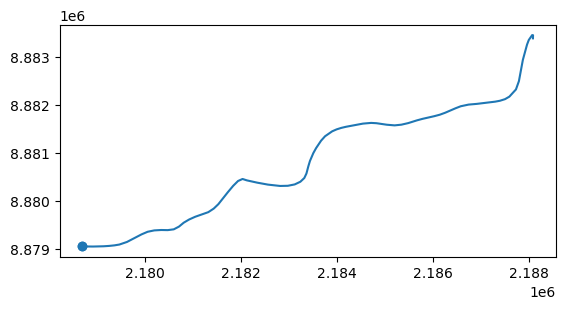

In [225]:
ax = gpd.GeoSeries(t_nearest_points).plot()
gpd.GeoSeries([t_polygon_half]).plot(ax = ax)

In [213]:
t_restrict_len

11600

In [178]:
        t_closest_points_on_drainage_limit = [shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
                                              shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]]

In [179]:
t_closest_points_on_drainage_limit

[array([<POINT (2129642.216 8836150.979)>,
        <POINT (2129642.216 8836150.979)>], dtype=object),
 array([<POINT (2129642.216 8836150.979)>,
        <POINT (2130918.246 8836394.819)>], dtype=object)]

In [168]:
get_sub_polygon([to_snap_points[3].coords[0], to_snap_points[4].coords[0]], mode = "inner", direction = "->").is_simple

False

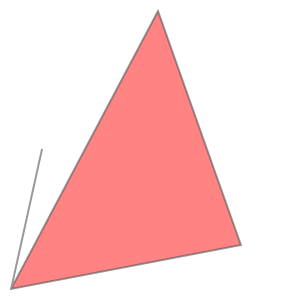

In [176]:
get_sub_polygon([to_snap_points[0].coords[0], to_snap_points[1].coords[0]], mode = "inner", direction = "->")

<Axes: >

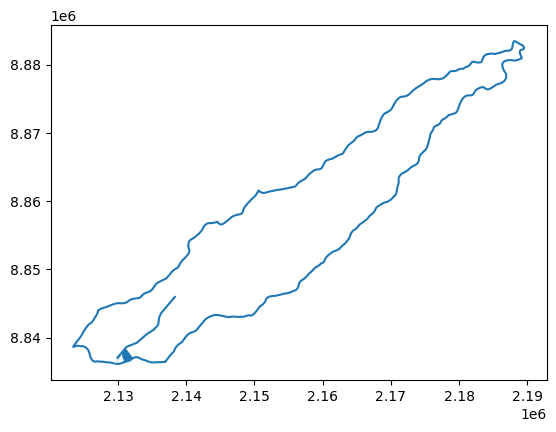

In [165]:
ax = gpd.GeoSeries(c_polygon_halves).plot()
gpd.GeoSeries([c_edge.geometry]).plot(ax = ax)
gpd.GeoSeries([get_sub_polygon([to_snap_points[1].coords[0], to_snap_points[2].coords[0]], mode = "inner", direction = "->")]).plot(ax=ax)

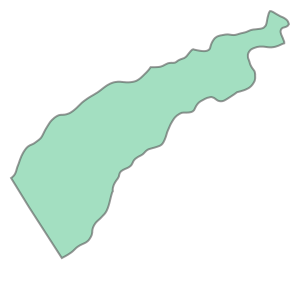

In [122]:
get_sub_polygon([c_edge.geometry.coords[0], c_edge.geometry.coords[-1]], mode = "edge", direction = "->")

In [52]:
query_points = [c_edge.geometry.coords[0], c_edge.geometry.coords[-1]]

In [53]:
t_closest_points_on_drainage_limit = [shapely.ops.nearest_points(shapely.Point(query_points[0]), c_polygon_halves)[1],
                                        shapely.ops.nearest_points(shapely.Point(query_points[-1]), c_polygon_halves)[1]]
t_sub_polygon = shapely.Polygon([
    query_points[0], t_closest_points_on_drainage_limit[0][0], t_closest_points_on_drainage_limit[1][0],
    query_points[-1], t_closest_points_on_drainage_limit[1][1], t_closest_points_on_drainage_limit[0][1]
    ])

<Axes: >

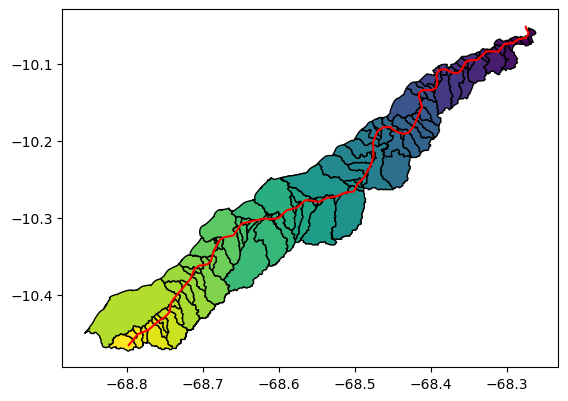

In [46]:
ax = test.plot(column = "distance_from_estuary", edgecolor = "black")
c_river.to_crs(4326).plot(ax=ax, color ="red")

In [51]:

def compute_drainage_areas(rivers, drainage_polygons):
    # join the polygons with the river network
    joined = drainage_polygons.sjoin(rivers, how="left", predicate = "intersects")
    # remove polygons with no corresponding river
    joined.dropna(subset = ["index_right0", "index_right1", "index_right2"], inplace = True)
    # create a tuple of river indices
    joined["index_right"] = joined.apply(lambda x: tuple([int(x.index_right0), int(x.index_right1), int(x.index_right2)]), axis = 1)
    # calculate the intersection length
    joined["intersection_length"] = joined.apply(lambda x: x.geometry.intersection(rivers.loc[x.index_right].geometry).length, axis = 1)
    # assign drainage polygons to rivers with longest intersection
    joined_assignment = joined[["estuary", "river"]].iloc[joined.reset_index().groupby("index").intersection_length.idxmax()]
    
    # join in the assignment and dissolve by river
    drainage_polygons = drainage_polygons.join(joined_assignment).to_crs(4326)
    drainage_polygons["geometry"] = drainage_polygons.geometry.buffer(0)
    drainage_polygons_dissolved = drainage_polygons.dissolve(["estuary", "river"]).reset_index()
    #pd.concat(joined_assignment.reset_index().apply(lambda x: joined.loc[[x["index"]]].query(f"estuary=={x.estuary} & river=={x.river}").reset_index()[["index", "index_right", "estuary", "river", "segment", "subsegment"]], axis = 1).tolist())
    return compute_polygons_river(drainage_polygons_dissolved.iloc[500], rivers, drainage_polygons)

#compute_drainage_areas(gpd.clip(rivers_brazil_shapefile, grid_data.iloc[[525]].total_bounds), gpd.clip(drainage_area_new, grid_data.iloc[[525]].total_bounds))
compute_drainage_areas(rivers_brazil_shapefile, drainage_area_new)

A


NameError: name 'compute_polygons_river' is not defined

In [ ]:
compute_polygons_river(drainage_polygons_dissolved.iloc[500], rivers_brazil_shapefile, drainage_area_new, height_profile)

0      Annotation(2.17218e+06, 8.79606e+06, '1576')
1      Annotation(2.15446e+06, 8.85604e+06, '3152')
2      Annotation(2.21966e+06, 8.85683e+06, '3178')
3      Annotation(2.19276e+06, 8.82596e+06, '3562')
4     Annotation(2.20818e+06, 8.88041e+06, '15796')
                          ...                      
93       Annotation(2.24029e+06, 8.80927e+06, '30')
94        Annotation(2.22361e+06, 8.8072e+06, '31')
95       Annotation(2.22642e+06, 8.80468e+06, '32')
96        Annotation(2.2305e+06, 8.80902e+06, '33')
97       Annotation(2.21026e+06, 8.80927e+06, '34')
Length: 98, dtype: object

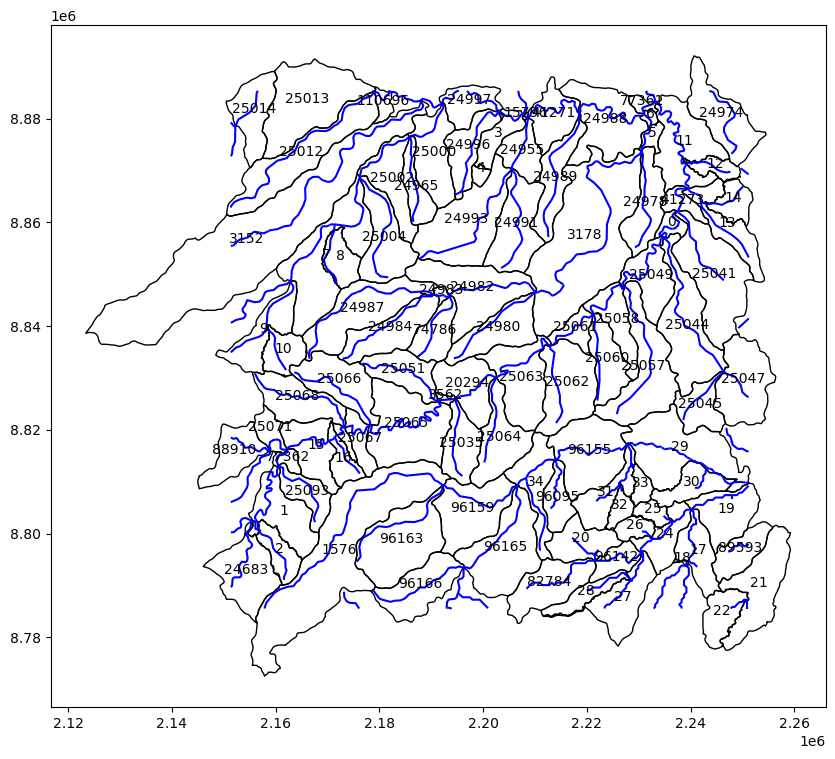

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
drainage_area_new.plot(ax=ax, edgecolor = "black", color="none")
#drainage_area.loc[drainage_area_gridded.index[drainage_area_gridded.index_left == 525].values].to_crs(5641).plot(ax = ax, color="none", edgecolor = "red", alpha=.2)
gpd.clip(rivers_brazil_shapefile, grid_data.iloc[[525]].total_bounds).plot(ax = ax, color = "blue")
drainage_area_new.reset_index().apply(lambda x: ax.annotate(text=x['index'], xy=x.geometry.centroid.coords[0], ha='center',), axis=1)